In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import os

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, ConstantKernel
from scipy.signal import blackman, 
from matplotlib import pyplot as plt; plt.rcParams['figure.figsize'] = 15, 5

DATA_DIR = '../data/interim/'
HDF_FILE = 'interim_data.hdf'

In [2]:
D = pd.read_hdf(DATA_DIR + HDF_FILE, key = '/temperature_ts/wban_CANA8')

In [3]:
D.head()

,T,T_flag
Time,,
1986-01-01 05:00:00,-19.0,0
1986-01-01 06:00:00,-20.1,0
1986-01-01 07:00:00,-20.8,0
1986-01-01 08:00:00,-21.8,0
1986-01-01 09:00:00,-22.8,0


There are some missing values in the time series data.  They are indicated by '-1' in the 'T_flag' column, and their numerical value is 9999.

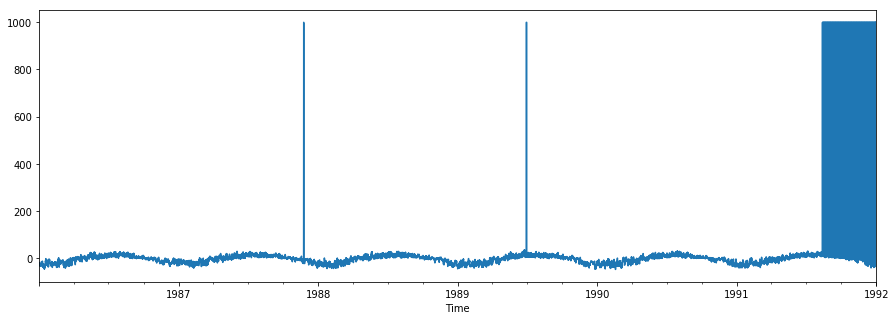

In [4]:
p = D.loc[:, 'T'].plot()
del p #Keep memory freed up.  Does this actually do anything?

It is fairly easy to remove these data points, but we need to interpolate them so that our sampling
rate is consistent.

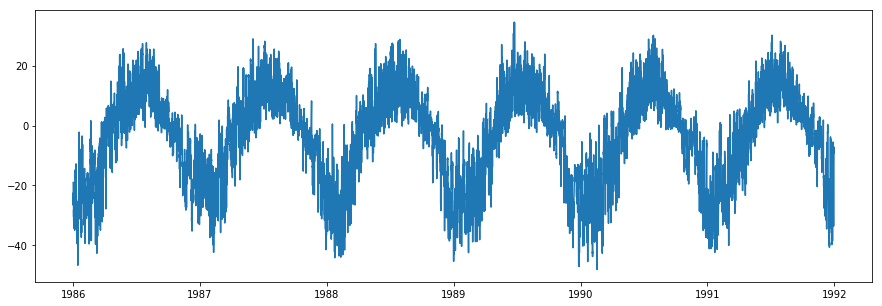

In [5]:
D = D.drop(D.index[D['T_flag'] == - 1])
p = plt.plot(D.loc[:, 'T'])
del p

I need to use some kind of model to impute the missing values.  I've considered using a Gaussian process.

In [6]:
unix_birth = datetime.datetime(1970, 1, 1)
time_in_days = lambda t: (t - unix_birth).total_seconds() / 86400
%timeit time_in_days(datetime.datetime(2017, 4, 26))

722 ns ± 2.03 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [12]:
#This is so brutally slow!
%timeit D['t'] = D.index.map(time_in_days)

603 µs ± 4.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


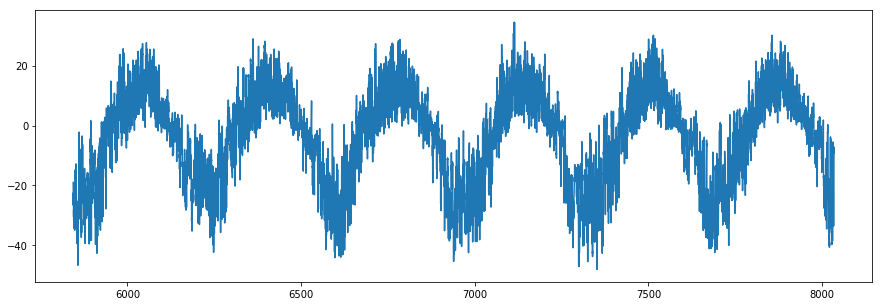

In [14]:
X = D['t'].values.reshape(-1, 1) #Time is the input
y = D['T'].values #Temperature is the output
p = plt.plot(X, y)
del p

In [15]:
mu = D['T'].mean()
D['T'] -= mu
del D

In [16]:
y -= mu

In [17]:
subsample = 8
N = 2500

#k1 = ConstantKernel() * ExpSineSquared(periodicity = 365.25 / subsample) #Yearly seasonality
k2 = ConstantKernel() * ExpSineSquared(periodicity = 1. / subsample) #Daily variations
k3 = ConstantKernel() * RationalQuadratic() 
k4 = ConstantKernel() * WhiteKernel()

K = k2 + k3 + k4
gpr = GaussianProcessRegressor(kernel = K, copy_X_train = False, optimizer = 'fmin_l_bfgs_b',
                               n_restarts_optimizer = 2)
X0, y0 = X[:N], y[:N]
X_train, y_train = X0[::subsample], y0[::subsample]

In [18]:
gpr = gpr.fit(X_train, y_train)

/home/ubuntu/.virtualenvs/dwglasso_cweeds/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 24, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 99, 'warnflag': 2, 'grad': array([ -1.14529201e+00,   8.46775859e+00,  -1.39337832e+08,
        -2.82187833e+00,  -3.27530755e+00,   1.10020111e-03,
        -1.90611572e-01,  -1.90611572e-01])}
  " state: %s" % convergence_dict)


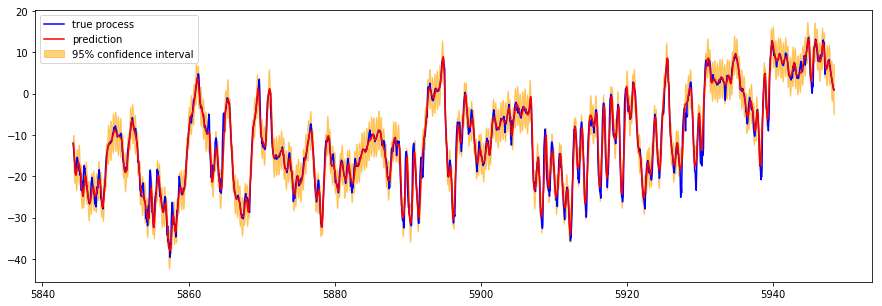

In [19]:
p = plt.plot(X0, y0, label = 'true process', color = 'blue')
y_pred, sigma = gpr.predict(X0, return_std = True)
p = plt.plot(X0, y_pred, label = 'prediction', color = 'red')
p = plt.fill(np.concatenate([X0, X0[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval', color = 'orange')
p = plt.legend()
del p

In [20]:
gpr.kernel_

6.68**2 * ExpSineSquared(length_scale=5.67, periodicity=3.74) + 13.2**2 * RationalQuadratic(alpha=0.101, length_scale=0.465) + 0.185**2 * WhiteKernel(noise_level=0.0342)

As cool as this is, GPs have O(N^3) time requirement and O(N^2) (I think?) memory.  I don't think it is suitable just to impute some missing data.